# Отбор признаков и снижение размерности

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Понижение размерности можно использовать для следующих целей:

* Сокращение ресурсоемкости алгоритмов
* Ослабление влияния проклятия размерности и тем самым уменьшение переобучения
* Переход к более информативным признакам

Сейчас мы будем понижать размерность ориентируясь как раз на эти цели.
Тогда этот процесс также можно называть и выделением признаков.

## Отбор признаков

Мы можем сократить количество исходных признаков несколькими способами. Первый - на основе **корреляции с целевой переменной**.

(506, 14)


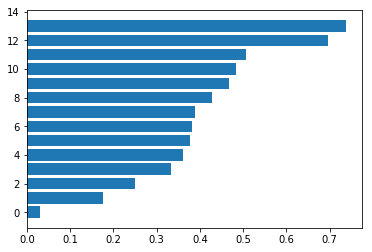

In [2]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

ds = load_boston()
X_, y = ds.data, ds.target

#добавим "мешающий" признак
X = np.zeros((X_.shape[0],X_.shape[1]+1))
X[:,:-1] = X_
curr = np.random.randint(2, size=506)
curr = np.array([elem if elem > 0 else elem-1 for elem in curr])
X[:,-1] = X[:,0]*curr
print(X.shape)

indices = np.arange(len(y))
np.random.shuffle(indices)
X = X[indices, :]
y = y[indices]

features_ind = np.arange(X.shape[1])
corrs = np.abs([np.corrcoef(X[:, i], y)[0][1] for i in features_ind])
importances_sort = np.argsort(corrs)
plt.barh(features_ind, corrs[importances_sort])
X = X[:, importances_sort]

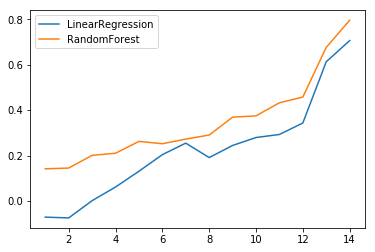

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

features_counts = np.arange(1, X.shape[1] + 1)

def scores_by_features_count(reg):
    scores = []
    for features_part in features_counts:
        X_part = X[:, :features_part]
        scores.append(cross_val_score(reg, X_part, y, cv=3).mean())
    return scores
    
plt.figure()
linreg_scores = scores_by_features_count(LinearRegression())
plt.plot(features_counts, linreg_scores, label='LinearRegression')

rf_scores = scores_by_features_count(RandomForestRegressor(n_estimators=100, max_depth=3))
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best')

Еще один способ отбора признаков - с помощью метода **SelectKBest**. Метод оставляет k признаков с самыми большими значениями некоторой статистики, которую используем для отбора. Приведем пример, в качестве статистики использующий совместную информацию признаков. Для признаков X и Y она задается следующей формулой:

$$I(X;Y)=\sum _{y\in Y}\sum _{x\in X}p(x,y)\log {\left({\frac {p(x,y)}{p(x)\,p(y)}}\right)}$$

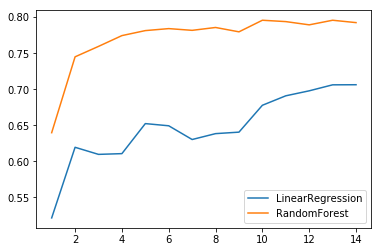

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression

def scores_by_kbest_count(reg):
    scores = []
    for features_part in features_counts:
        X_new = SelectKBest(mutual_info_regression, k=features_part).fit_transform(X, y)
        scores.append(cross_val_score(reg, X_new, y, cv=3).mean())
    return scores
    
#Plot results of SelectKBest
#Your code is here
plt.figure()
linreg_scores2 = scores_by_kbest_count(LinearRegression())
plt.plot(features_counts, linreg_scores2, label='LinearRegression')

rf_scores2 = scores_by_kbest_count(RandomForestRegressor(n_estimators=100, max_depth=3))
plt.plot(features_counts, rf_scores2, label='RandomForest')
plt.legend(loc='best')

**Рекурсивный отбор признаков**

Выбираем алгоритм (estimator), применяем его, и он в результате своей работы присваивает веса всем признакам. Затем откидываем наименее важные признаки и снова запускаем estimator и т.д., до тех пор, пока не останется заранее заданное число признаков.

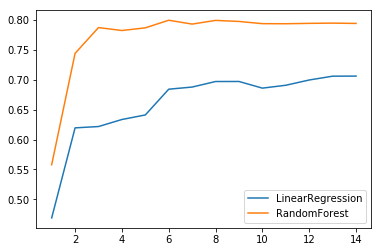

In [14]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

def scores_by_rfe_count(reg):
    scores = []
    for features_part in features_counts:
        
        est = RandomForestRegressor(n_estimators=10, max_depth=3)
        #Try another estimators. Which one is the best?
        
        X_rfe = RFE(estimator=est, n_features_to_select=features_part, step=1).fit_transform(X, y)
        scores.append(cross_val_score(reg, X_rfe, y, cv=3).mean())
    return scores
    
#Plot results of RFE
#Your code is here
plt.figure()
linreg_scores3 = scores_by_rfe_count(LinearRegression())
plt.plot(features_counts, linreg_scores3, label='LinearRegression')

rf_scores3 = scores_by_rfe_count(RandomForestRegressor(n_estimators=100, max_depth=3))
plt.plot(features_counts, rf_scores3, label='RandomForest')
plt.legend(loc='best')

Мы видим, что последние два метода при использовании RandomForestRegressor позволяют нам оставить довольно мало признаков, что существенно ускоряет нас.

## Метод главных компонент (Principal Component Analysis, PCA)

Выделение новых признаков путем их отбора часто дает плохие результаты, и
в некоторых ситуациях такой подход практически бесполезен. Например, если
мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о
содержимом картинки. 

Поэтому признаки нужно как-то комбинировать. Рассмотрим метод главных компонент.

Этот метод делает два важных упрощения задачи

1. Игнорируется целевая переменная
2. Строится линейная комбинация признаков

П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является
таким уж плохим. Это связано с тем, что часто данные устроены так, что имеют какую-то
внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с
целевой переменной. Поэтому и оптимальные признаки можно строить не глядя на ответ.

П. 2 тоже сильно упрощает задачу, но далее мы научимся избавляться от него.

### Теория

Обозначим $X$ - матрица объекты-признаки, с нулевым средним каждого признака,
а $w$ - некоторый единичный вектор. Тогда
$Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор,
который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию
вдоль этого направления):

$$
    \max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным
значением. После этого все пространство проецируется на ортогональное дополнение к вектору
$w$ и процесс повторяется.

### PCA на плоскости

Для начала посмотрим на метод PCA на плоскости для того, чтобы
лучше понять, как он устроен.

Создадим выборку из двух сильно зависящих признаков.

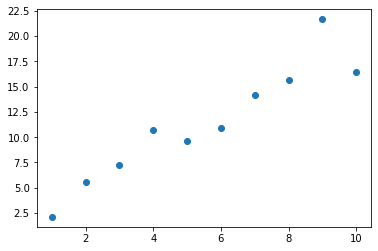

In [4]:
x = np.arange(1,11)
y = 2 * x + np.random.randn(10)*2
X = np.vstack((x,y))

plt.scatter(X[0],X[1])

Mean vector:  [ 5.5        11.40472555]
[[-4.5        -3.5        -2.5        -1.5        -0.5         0.5
   1.5         2.5         3.5         4.5       ]
 [-9.29373869 -5.86919667 -4.1572416  -0.6851998  -1.75888295 -0.51420064
   2.71985257  4.26303233 10.25786643  5.03770902]]


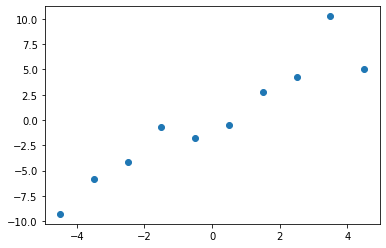

In [5]:
#Find m - mean vector, and Xcentered - X-mean
#Your code is here
Xcentered = X - X.mean(axis=1, keepdims=True)
m = np.mean(X, axis=1)

print("Mean vector: ", m)
print(Xcentered)

plt.scatter(Xcentered[0],Xcentered[1])

Вычисляем матрицу ковариаций

In [6]:
covmat = np.cov(Xcentered)
print(covmat, "\n")
print("Variance of X: ", np.cov(Xcentered)[0,0])
print("Variance of Y: ", np.cov(Xcentered)[1,1])
print("Covariance X and Y: ", np.cov(Xcentered)[0,1])

[[ 9.16666667 16.41298223]
 [16.41298223 33.12273943]] 

Variance of X:  9.166666666666666
Variance of Y:  33.122739434515466
Covariance X and Y:  16.412982231069275


Находим собственные векторы матрицы ковариаций и проецируем на самый большой вектор (с самым большим собственным значением) все точки

In [7]:
eignums, vecs = np.linalg.eig(covmat)
v = vecs[:,np.argmax(eignums)]
Xnew = np.dot(v,Xcentered)
print(Xnew)

[ 10.32395583   6.81797368   4.83874191   1.29041429   1.79454505
   0.23188126  -3.10428244  -4.93305306 -10.73041927  -6.52975725]


Восстановление данных

In [8]:
n = 3 #номер элемента случайной величины
Xrestored = np.dot(Xnew[n],v) + m
print('Restored: ', Xrestored)
print('Original: ', X[:,n])

Restored:  [ 4.91538467 10.25433694]
Original:  [ 4.         10.71952575]


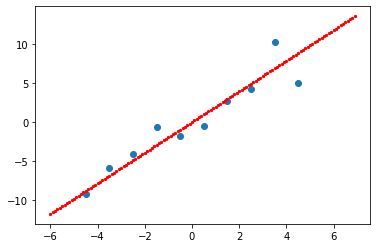

In [9]:
k = v[1]/v[0]

x1 = np.arange(-6,7,0.1)
y1 = [k*elem for elem in x1]
plt.scatter(Xcentered[0],Xcentered[1])
plt.scatter(x1,y1,color='red',s=5)
plt.show()

Доля объясненной дисперсии

In [10]:
100 * max(eignums)/sum(eignums)

98.04735353646893

Проверим, что нам выдаст PCA из sklearn

In [11]:
from sklearn.decomposition import PCA

#Apply PCA with n_components=1 to transposed Xcentered
#Your code is here
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xcentered.T)

In [12]:
pca.components_

array([[ 0.45304468,  0.89148781],
       [ 0.89148781, -0.45304468]])

In [13]:
Xcentered

array([[-4.5       , -3.5       , -2.5       , -1.5       , -0.5       ,
         0.5       ,  1.5       ,  2.5       ,  3.5       ,  4.5       ],
       [-9.29373869, -5.86919667, -4.1572416 , -0.6851998 , -1.75888295,
        -0.51420064,  2.71985257,  4.26303233, 10.25786643,  5.03770902]])

In [14]:
X_pca

array([[-10.32395583,   0.19878374],
       [ -6.81797368,  -0.461199  ],
       [ -4.83874191,  -0.34530333],
       [ -1.29041429,  -1.02680559],
       [ -1.79454505,   0.35110866],
       [ -0.23188126,   0.67869977],
       [  3.10428244,   0.10501697],
       [  4.93305306,   0.2973754 ],
       [ 10.73041927,  -1.52706449],
       [  6.52975725,   1.72938787]])

Сравним полученный вектор главной компоненты с нашим ответом

In [15]:
print(v)
print(pca.components_)

[-0.45304468 -0.89148781]
[[ 0.45304468  0.89148781]
 [ 0.89148781 -0.45304468]]


Доля объясненного разброса по мнению встроенного PCA

In [16]:
pca.explained_variance_ratio_[0] * 100

98.04735353646893

c:\programdata\miniconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\elena\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, '')]

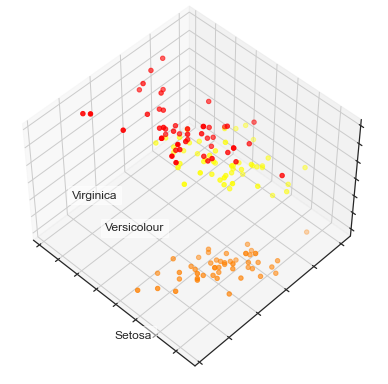

In [17]:
import seaborn as sns; sns.set(style='white')
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# Загрузим наши ирисы
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Заведём красивую трёхмерную картинку
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Поменяем порядок цветов меток, чтобы они соответствовали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.autumn)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

NameError: name 'X_lda' is not defined

In [ ]:
from sklearn.decomposition import PCA
%pylab inline

#Apply PCA with n_components = 2. Don't forget to subtract mean from matrix X!
#Your code is here
Xc = X - X.mean(axis=1, keepdims=True)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xc)

#Нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [ ]:
#Caclculate accuracy on reduced data

In [ ]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

# LDA (Linear Discriminant Analisys)

При помощи метода линейного дискриминантного анализа выбирается проекция исходного пространства признаков на пространство признаков таким образом, чтобы минимизировать разброс точек внутри класса и максимизировать межклассовое расстояние в пространстве признаков.

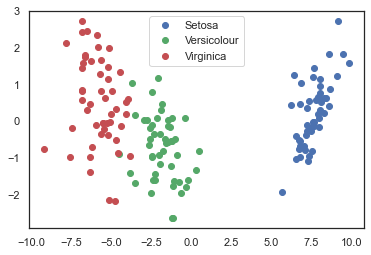

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Xsc = scaler.fit_transform(X)

lda = LDA(n_components=2)
X_lda = lda.fit(Xsc,y).transform(Xsc)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_lda[y == 0, 0], X_lda[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_lda[y == 1, 0], X_lda[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_lda[y == 2, 0], X_lda[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [ ]:
#Caclculate accuracy on new data after LDA